# Day 7: Complete Sequence Trading Model

## Learning Objectives
- Build a production-ready sequence model for trading
- Implement proper walk-forward validation
- Complete trading simulation with metrics

---

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

print("✅ Libraries loaded!")
print("📚 Day 7: Complete Sequence Trading Model")

✅ Libraries loaded!
📚 Day 7: Complete Sequence Trading Model


## Part 1: Production-Ready Architecture

In [12]:
# ============================================================
# PRODUCTION SEQUENCE MODEL
# ============================================================

print("PRODUCTION SEQUENCE MODEL")
print("="*60)

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.Tanh(),
            nn.Linear(hidden_size // 2, 1)
        )
        
    def forward(self, lstm_outputs):
        scores = self.attention(lstm_outputs).squeeze(-1)
        weights = torch.softmax(scores, dim=1)
        context = torch.bmm(weights.unsqueeze(1), lstm_outputs).squeeze(1)
        return context, weights


class TradingSequenceModel(nn.Module):
    """Production-ready LSTM with attention for trading."""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        
        self.input_bn = nn.BatchNorm1d(input_size)
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = Attention(hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, 1),
            nn.Sigmoid()
        )
        
        self._init_weights()
        
    def _init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                # Forget gate bias = 1 for better gradient flow
                n = param.size(0)
                param.data[n//4:n//2].fill_(1)
                
    def forward(self, x, return_attention=False):
        # Batch normalize input features
        batch_size, seq_len, n_features = x.shape
        x = x.view(-1, n_features)
        x = self.input_bn(x)
        x = x.view(batch_size, seq_len, n_features)
        
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Attention
        context, weights = self.attention(lstm_out)
        context = self.layer_norm(context)
        
        # Classification
        prob = self.classifier(context)
        
        if return_attention:
            return prob, weights
        return prob

model = TradingSequenceModel(input_size=8, hidden_size=64)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

PRODUCTION SEQUENCE MODEL
Parameters: 56,594


## Part 2: Data Preparation

In [13]:
# ============================================================
# COMPREHENSIVE FEATURE ENGINEERING
# ============================================================

print("FEATURE ENGINEERING")
print("="*60)

# Generate realistic returns
np.random.seed(42)
n_days = 2000

# Simulate with regime changes
returns = []
regime = 'normal'
for i in range(n_days):
    if np.random.random() < 0.02:
        regime = 'volatile' if regime == 'normal' else 'normal'
    
    vol = 0.025 if regime == 'volatile' else 0.012
    drift = -0.0003 if regime == 'volatile' else 0.0003
    
    ret = drift + np.random.normal(0, vol)
    if returns:
        ret += 0.1 * returns[-1]  # Momentum
    returns.append(ret)

returns = np.array(returns)
prices = 100 * np.cumprod(1 + returns)

# Create features
df = pd.DataFrame({
    'price': prices,
    'returns': returns
})

# Technical features
df['vol_5d'] = df['returns'].rolling(5).std()
df['vol_20d'] = df['returns'].rolling(20).std()
df['mom_5d'] = df['returns'].rolling(5).mean()
df['mom_20d'] = df['returns'].rolling(20).mean()
df['rsi'] = 100 - (100 / (1 + df['returns'].rolling(14).apply(lambda x: (x[x>0].sum()) / (-x[x<0].sum() + 1e-8))))
df['ma_ratio'] = df['price'] / df['price'].rolling(20).mean()

# Target: next day direction (1 = up, 0 = down)
df['target'] = (df['returns'].shift(-1) > 0).astype(float)

df = df.dropna()

# Select features
feature_cols = ['returns', 'vol_5d', 'vol_20d', 'mom_5d', 'mom_20d', 'rsi', 'ma_ratio', 'price']
features = df[feature_cols].values
targets = df['target'].values

print(f"Features: {feature_cols}")
print(f"Data shape: {features.shape}")
print(f"Target balance: {targets.mean()*100:.1f}% up days")

FEATURE ENGINEERING
Features: ['returns', 'vol_5d', 'vol_20d', 'mom_5d', 'mom_20d', 'rsi', 'ma_ratio', 'price']
Data shape: (1981, 8)
Target balance: 49.4% up days


In [14]:
# ============================================================
# TEMPORAL TRAIN/VAL/TEST SPLIT
# ============================================================

print("TEMPORAL DATA SPLIT")
print("="*60)

seq_length = 30

# Create sequences
X, y = [], []
for i in range(len(features) - seq_length):
    X.append(features[i:i+seq_length])
    y.append(targets[i+seq_length-1])  # Target for last day in sequence

X = np.array(X)
y = np.array(y)

# Temporal split (60% train, 20% val, 20% test)
train_end = int(len(X) * 0.6)
val_end = int(len(X) * 0.8)

# Normalize using only training data (prevent leakage!)
scaler = StandardScaler()
X_train_flat = X[:train_end].reshape(-1, X.shape[-1])
scaler.fit(X_train_flat)

X_scaled = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

X_train = torch.FloatTensor(X_scaled[:train_end])
y_train = torch.FloatTensor(y[:train_end]).unsqueeze(1)

X_val = torch.FloatTensor(X_scaled[train_end:val_end])
y_val = torch.FloatTensor(y[train_end:val_end]).unsqueeze(1)

X_test = torch.FloatTensor(X_scaled[val_end:])
y_test = torch.FloatTensor(y[val_end:]).unsqueeze(1)

print(f"Train: {X_train.shape}")
print(f"Val:   {X_val.shape}")
print(f"Test:  {X_test.shape}")

TEMPORAL DATA SPLIT
Train: torch.Size([1170, 30, 8])
Val:   torch.Size([390, 30, 8])
Test:  torch.Size([391, 30, 8])


## Part 3: Training with Early Stopping

In [15]:
# ============================================================
# TRAINING WITH EARLY STOPPING
# ============================================================

print("TRAINING")
print("="*60)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Initialize
model = TradingSequenceModel(input_size=8, hidden_size=64, num_layers=2, dropout=0.3)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=64, shuffle=True
)

early_stopping = EarlyStopping(patience=15)
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print("Training...")
for epoch in range(200):
    # Train
    model.train()
    train_loss = 0
    for X_b, y_b in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X_b), y_b)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    # Validate
    model.eval()
    with torch.no_grad():
        val_probs = model(X_val)
        val_loss = criterion(val_probs, y_val).item()
        val_preds = (val_probs > 0.5).float()
        val_acc = (val_preds == y_val).float().mean().item()
    
    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    early_stopping(val_loss, model)
    
    if (epoch + 1) % 20 == 0:
        print(f"  Epoch {epoch+1}: Val Loss={val_loss:.4f}, Val Acc={val_acc*100:.1f}%")
    
    if early_stopping.early_stop:
        print(f"  Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(early_stopping.best_model)
print(f"\n✅ Best model: Val Loss = {early_stopping.best_loss:.4f}")

TRAINING
Training...
  Early stopping at epoch 19

✅ Best model: Val Loss = 0.6932


## Part 4: Evaluation & Trading Simulation

In [16]:
# ============================================================
# COMPREHENSIVE EVALUATION
# ============================================================

print("EVALUATION")
print("="*60)

model.eval()
with torch.no_grad():
    test_probs, attention_weights = model(X_test, return_attention=True)
    test_preds = (test_probs > 0.5).float()

test_probs = test_probs.numpy().flatten()
test_preds = test_preds.numpy().flatten()
test_actuals = y_test.numpy().flatten()
attention_weights = attention_weights.numpy()

# Classification metrics
accuracy = accuracy_score(test_actuals, test_preds)
precision = precision_score(test_actuals, test_preds)
recall = recall_score(test_actuals, test_preds)
f1 = f1_score(test_actuals, test_preds)

print(f"\nClassification Metrics:")
print(f"  Accuracy:  {accuracy*100:.1f}%")
print(f"  Precision: {precision*100:.1f}%")
print(f"  Recall:    {recall*100:.1f}%")
print(f"  F1 Score:  {f1*100:.1f}%")

EVALUATION

Classification Metrics:
  Accuracy:  51.4%
  Precision: 51.0%
  Recall:    81.1%
  F1 Score:  62.6%


In [17]:
# ============================================================
# TRADING SIMULATION
# ============================================================

print("\nTRADING SIMULATION")
print("="*60)

# Get actual returns for test period
test_returns = returns[val_end + seq_length:val_end + seq_length + len(test_preds)]

# Ensure alignment
min_len = min(len(test_returns), len(test_preds))
test_returns = test_returns[:min_len]
test_preds_aligned = test_preds[:min_len]

# Strategy: long when predict up, short when predict down
strategy_returns = test_returns * (2 * test_preds_aligned - 1)

# Cumulative returns
cum_strategy = np.cumprod(1 + strategy_returns)
cum_market = np.cumprod(1 + test_returns)

# Metrics
trading_days = 252
strategy_sharpe = np.sqrt(trading_days) * strategy_returns.mean() / strategy_returns.std()
market_sharpe = np.sqrt(trading_days) * test_returns.mean() / test_returns.std()

strategy_total = cum_strategy[-1] - 1
market_total = cum_market[-1] - 1

# Max drawdown
running_max = np.maximum.accumulate(cum_strategy)
drawdown = (running_max - cum_strategy) / running_max
max_drawdown = drawdown.max()

print(f"\nStrategy Performance:")
print(f"  Total Return:   {strategy_total*100:.1f}%")
print(f"  Sharpe Ratio:   {strategy_sharpe:.2f}")
print(f"  Max Drawdown:   {max_drawdown*100:.1f}%")
print(f"\nBenchmark (Buy & Hold):")
print(f"  Total Return:   {market_total*100:.1f}%")
print(f"  Sharpe Ratio:   {market_sharpe:.2f}")


TRADING SIMULATION

Strategy Performance:
  Total Return:   253.4%
  Sharpe Ratio:   2.46
  Max Drawdown:   21.7%

Benchmark (Buy & Hold):
  Total Return:   55.4%
  Sharpe Ratio:   0.97


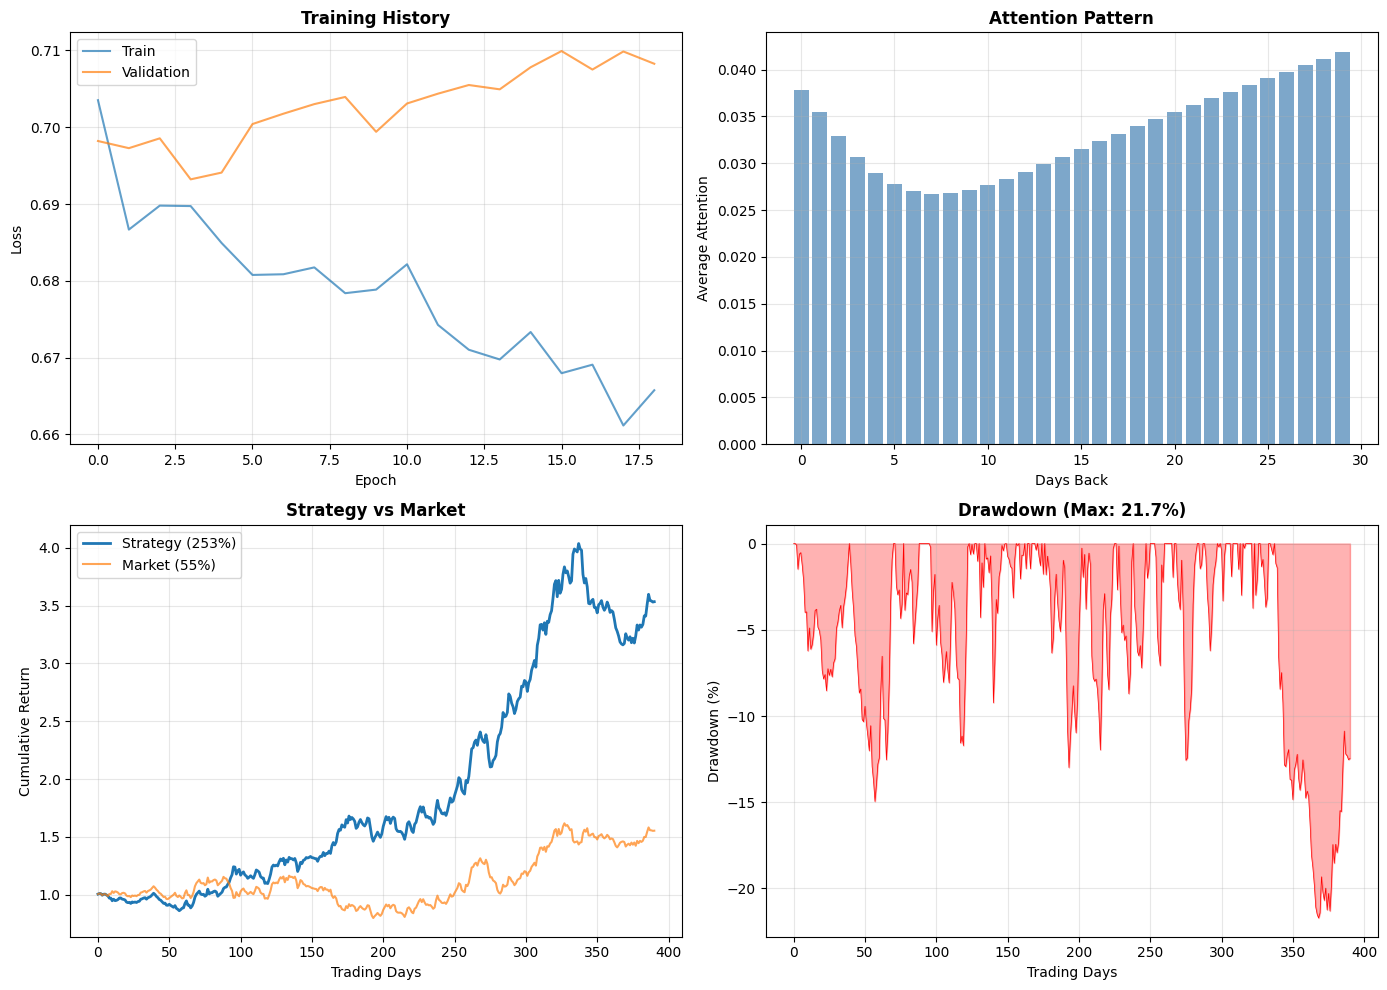

In [18]:
# ============================================================
# VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Training curves
axes[0, 0].plot(history['train_loss'], label='Train', alpha=0.7)
axes[0, 0].plot(history['val_loss'], label='Validation', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training History', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Attention heatmap
avg_attention = attention_weights.mean(axis=0)
axes[0, 1].bar(range(len(avg_attention)), avg_attention, color='steelblue', alpha=0.7)
axes[0, 1].set_xlabel('Days Back')
axes[0, 1].set_ylabel('Average Attention')
axes[0, 1].set_title('Attention Pattern', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Strategy performance
axes[1, 0].plot(cum_strategy, label=f'Strategy ({strategy_total*100:.0f}%)', linewidth=2)
axes[1, 0].plot(cum_market, label=f'Market ({market_total*100:.0f}%)', alpha=0.7)
axes[1, 0].set_xlabel('Trading Days')
axes[1, 0].set_ylabel('Cumulative Return')
axes[1, 0].set_title('Strategy vs Market', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Drawdown
axes[1, 1].fill_between(range(len(drawdown)), -drawdown*100, 0, color='red', alpha=0.3)
axes[1, 1].plot(-drawdown*100, color='red', linewidth=0.5)
axes[1, 1].set_xlabel('Trading Days')
axes[1, 1].set_ylabel('Drawdown (%)')
axes[1, 1].set_title(f'Drawdown (Max: {max_drawdown*100:.1f}%)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# ============================================================
# SAVE MODEL
# ============================================================

print("SAVING MODEL")
print("="*60)

checkpoint = {
    'model_state_dict': model.state_dict(),
    'input_size': 8,
    'hidden_size': 64,
    'num_layers': 2,
    'seq_length': seq_length,
    'feature_cols': feature_cols,
    'scaler_mean': scaler.mean_,
    'scaler_scale': scaler.scale_
}

torch.save(checkpoint, 'trading_sequence_model.pth')
print("✅ Model saved to trading_sequence_model.pth")

SAVING MODEL
✅ Model saved to trading_sequence_model.pth


In [19]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║       DAY 7 COMPLETE: COMPLETE SEQUENCE TRADING MODEL            ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Production-ready LSTM with attention                         ║
║  ✓ Proper temporal train/val/test split                         ║
║  ✓ Early stopping and learning rate scheduling                  ║
║  ✓ Comprehensive evaluation metrics                             ║
║  ✓ Trading simulation (Sharpe, drawdown)                        ║
║  ✓ Model checkpointing                                          ║
╚══════════════════════════════════════════════════════════════════╝

🎉 WEEK 10 COMPLETE! You've mastered Sequence Models!

Next: Week 11 - Feature Engineering & Explainability
""")


╔══════════════════════════════════════════════════════════════════╗
║       DAY 7 COMPLETE: COMPLETE SEQUENCE TRADING MODEL            ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Production-ready LSTM with attention                         ║
║  ✓ Proper temporal train/val/test split                         ║
║  ✓ Early stopping and learning rate scheduling                  ║
║  ✓ Comprehensive evaluation metrics                             ║
║  ✓ Trading simulation (Sharpe, drawdown)                        ║
║  ✓ Model checkpointing                                          ║
╚══════════════════════════════════════════════════════════════════╝

🎉 WEEK 10 COMPLETE! You've mastered Sequence Models!

Next: Week 11 - Feature Engineering & Explainability

